In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import seaborn as sns

In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K
# Use Tensorboard for network visualization & debugging
from tensorflow.keras.callbacks import TensorBoard
import sklearn.metrics
# import regularizer(s)
from tensorflow.keras.regularizers import l1, l2, l1_l2
# import Dropout
from tensorflow.keras.layers import Dropout
# import activation seperately
from tensorflow.keras.layers import Activation

In [50]:
V52_data = pd.read_csv('V52_data_process.csv')
# make Date the index in datetime format
V52_data.index = pd.to_datetime(V52_data['Date'], format='%Y%m%d%H%M')

data_AS03 = pd.read_csv('WindData_AS03.csv')
# make Date the index in datetime format
data_AS03.index = pd.to_datetime(data_AS03['date_time'], format='%Y-%m-%d %H:%M:%S')

V52_data['ActPow'].describe()

count    37068.000000
mean       199.045323
std        215.242947
min          0.009043
25%         49.789100
50%        112.594000
75%        259.734500
max        867.900000
Name: ActPow, dtype: float64

just a quick visual check

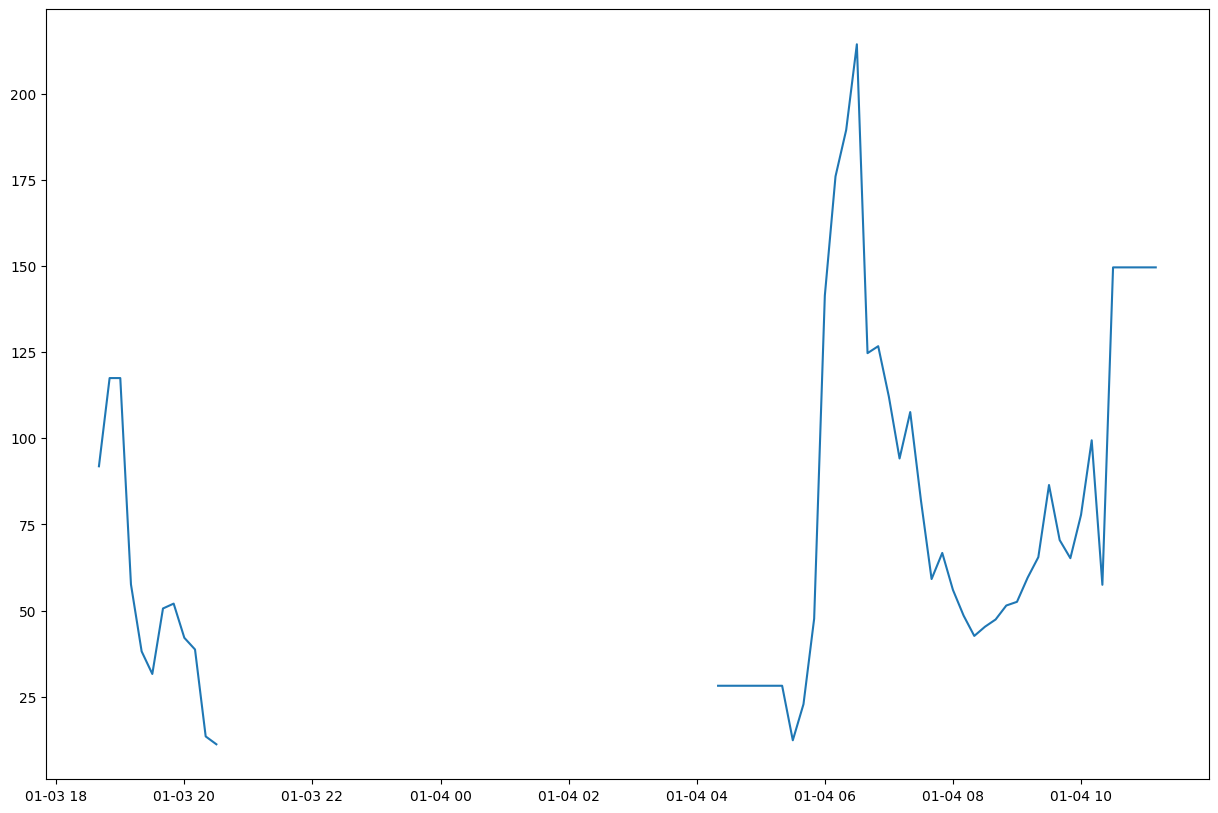

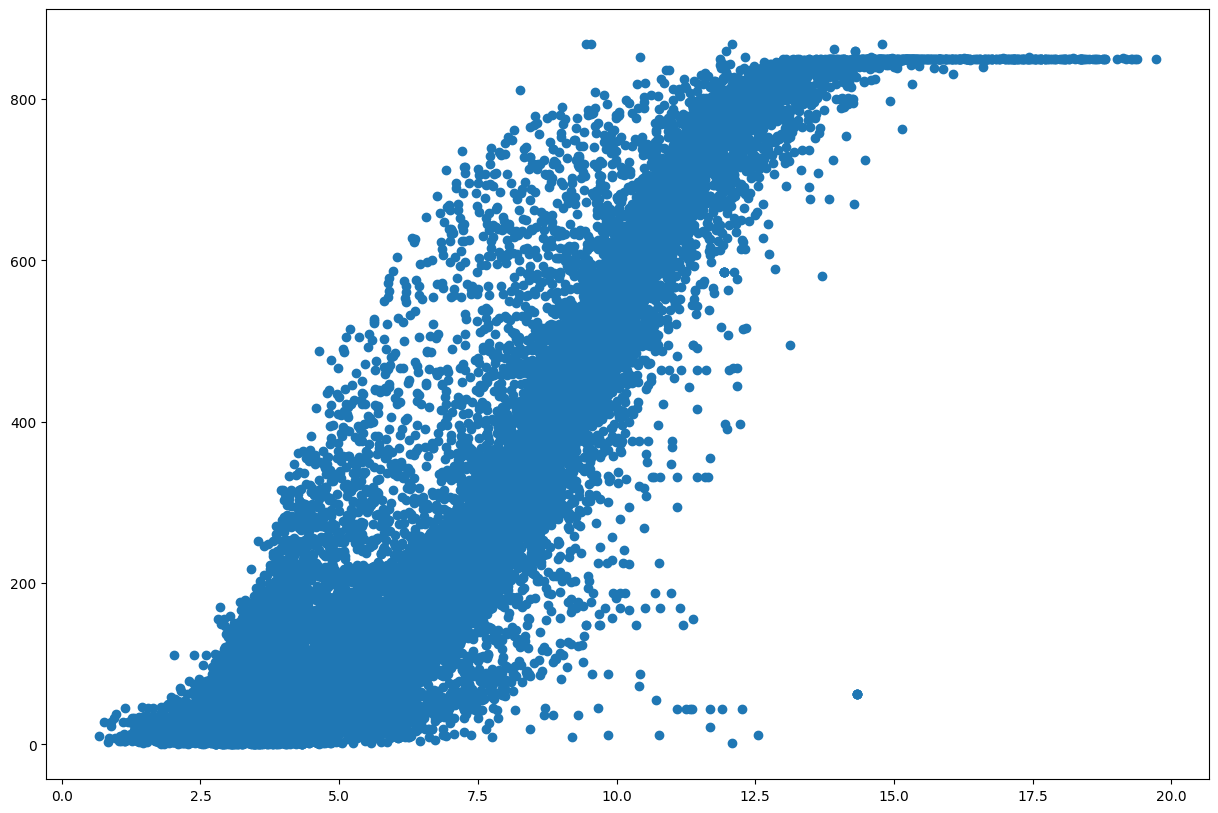

In [51]:
# plot the power signal of V52
plt.figure(figsize=(15, 10))
plt.plot(V52_data.index[400:500], V52_data['ActPow'][400:500], label='Power')

# plot a scatter 
plt.figure(figsize=(15, 10))
plt.scatter(V52_data['Wsp_44m'], V52_data['ActPow'], label='Power')

## With a continous data set we can begin a LSTM model

## Additional info on the time series processing - things to watch out!
1. **Non-stationary data** 
<br>‘Stationarity’ is one of the most important concepts you will come across when working with time series data. A stationary series is one in which the properties – mean, variance and covariance, **do not** vary with time.
<br>  Always keep in mind that in order to use time series forecasting models, it is necessary to convert any non-stationary series to a stationary series first. There are mainly two ways to do this:
     <br> 1.1 ***Differencing (one or multiple steps)***   $\rightarrow y_{diff}=y_{t}-y_{t-n} $ Pandas diff can directly be used or you can use df.shift(n) to extract $y_{t-n}$ 
     <br> 1.2 ***Axis transformations*** $\rightarrow$ e.g. log-transform can also help depending on your data. Also note that you can repeat the differencing several times until you reach the 'desired' stationarity.
2. **Scaling**
<br>As discussed (and demonstrated) above.
3. **LSTM particular input shape**
<br> Think thorough on samples, timesteps, features and what they represent for your data and problem at hand. In general, it goes as "how many features you would like to feed into the model at a time (timesteps) and how many of those sequences do you have? Let's do an example for our forecasting problem at hand...
3. **Inverse transform the output**
<br> Different than 'just' a binary classification, the output of your model might have units and non-stationary structure as well. Remember to inverse transform of your model predictions to deliver the 'true value' of your outputs.

## Divide Time series into Sequences
We will define 2 useful functions that will generate sequences of input + output intervals.

* The input interval is based on how much further back you would like to add to the memory
* The output interval depends on the forecast horizon for your problem


The input interval is one of the *hyperparameters* to tune. We can start with an initial guess and adjust it to see if we can get a performance increase.

In [52]:
### define a function that will prepare the shifting input sequences for the network
def forecast_sequences_input(input_data, n_lag):
    """
    A function that will split the input time series to sequences for nowcast/forecast problems
    Arguments:
        input_data: Time series of input observations as a list, NumPy array or pandas series
        n_lag: number of previous time steps to use for training, a.k.a. time-lag        
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = input_data.shape[1] 
    df = pd.DataFrame(input_data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_lag, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together (aggregate)
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg


### define a function that will prepare the shifting output sequences of the network
def forecast_sequences_output(output_data,n_out):
    """
    A function that will split the output time series to sequences for nowcast/forecast problems
    Arguments:
        output_data: Time series of input observations as a list, NumPy array or pandas series
        n_out: forecast horizon (for multi-output forecast)
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = output_data.shape[1] 
    df = pd.DataFrame(output_data)
    cols, names = list(), list()
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together (aggregate)
    agg = pd.concat(cols, axis=1)
    agg.columns = names    
    return agg


### Define length of the input and output intervals within the sequences

In [53]:
n_lag = 72 # number of previous time steps to use for training, a.k.a. time-lag
n_out = 36  # forecast hoizon: number of next time steps we will predict 1 = the next 10-min mean

### Define training, validation and test data as before, let's use dataframes this time
INPUTS:   
   1. Power
   2. std of power

OUTPUT:
   1. future power 


Sequence creation

In [54]:
### Split data into train & test 
train_int = int(0.6*len(V52_data))      # 60% of the data length for training
validation_int = int(0.8*len(V52_data)) # 20% more for validation

# training input vector
X_train = V52_data[['ActPow','ActPow_std','Wsp_44m','Wsp_44m_std']][:train_int]
X_train = forecast_sequences_input(X_train ,n_lag)

# training output vector
Y_train = V52_data[['ActPow']][:train_int]
Y_train = forecast_sequences_output(Y_train, n_out)

# validation input vector
X_validation = V52_data[['ActPow','ActPow_std','Wsp_44m','Wsp_44m_std']][train_int:validation_int]
X_validation = forecast_sequences_input(X_validation,n_lag)

# validation output vector
Y_validation = V52_data[['ActPow']][train_int:validation_int]
Y_validation = forecast_sequences_output(Y_validation, n_out)

# test input vector
X_test = V52_data[['ActPow','ActPow_std','Wsp_44m','Wsp_44m_std']][validation_int:]
X_test = forecast_sequences_input(X_test,n_lag)

# test output vector
Y_test = V52_data[['ActPow']][validation_int:]
Y_test = forecast_sequences_output(Y_test, n_out)

In [55]:
X_train

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var1(t-71),var2(t-71),var3(t-71),var4(t-71),var1(t-70),var2(t-70),...,var3(t-3),var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1)
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,64.6673,33.4251,4.71803,0.566131
2018-01-01 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,64.6673,33.4251,4.71803,0.566131,70.8152,26.3829,5.44100,0.765691
2018-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.71803,0.566131,70.8152,26.3829,5.44100,0.765691,80.8037,30.2002,5.32178,0.603442
2018-01-01 00:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.44100,0.765691,80.8037,30.2002,5.32178,0.603442,86.1123,43.1192,5.95325,0.872915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-07 23:10:00,54.1903,34.1157,4.93483,1.045340,51.0811,34.8696,4.80948,0.850036,59.9986,46.0580,...,7.22891,1.341690,175.0950,44.6526,6.23930,1.170930,209.5140,47.2370,6.51567,1.364550
2018-08-07 23:20:00,51.0811,34.8696,4.80948,0.850036,59.9986,46.0580,4.90219,1.092410,55.4411,35.6578,...,6.23930,1.170930,209.5140,47.2370,6.51567,1.364550,232.8220,55.5431,6.91831,1.291900
2018-08-07 23:30:00,59.9986,46.0580,4.90219,1.092410,55.4411,35.6578,5.10438,1.005630,94.9325,45.3717,...,6.51567,1.364550,232.8220,55.5431,6.91831,1.291900,220.9390,44.2433,7.00994,1.342040


In [56]:
Y_train

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6),var1(t+7),var1(t+8),var1(t+9),...,var1(t+26),var1(t+27),var1(t+28),var1(t+29),var1(t+30),var1(t+31),var1(t+32),var1(t+33),var1(t+34),var1(t+35)
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,64.6673,70.8152,80.8037,86.1123,110.8570,106.1850,60.0936,39.2994,45.9785,69.2233,...,39.2010,48.2353,49.7949,65.9946,75.1853,109.738,190.264,125.585,158.937,179.346
2018-01-01 00:10:00,70.8152,80.8037,86.1123,110.8570,106.1850,60.0936,39.2994,45.9785,69.2233,45.4030,...,48.2353,49.7949,65.9946,75.1853,109.7380,190.264,125.585,158.937,179.346,315.886
2018-01-01 00:20:00,80.8037,86.1123,110.8570,106.1850,60.0936,39.2994,45.9785,69.2233,45.4030,30.9105,...,49.7949,65.9946,75.1853,109.7380,190.2640,125.585,158.937,179.346,315.886,267.371
2018-01-01 00:30:00,86.1123,110.8570,106.1850,60.0936,39.2994,45.9785,69.2233,45.4030,30.9105,37.2575,...,65.9946,75.1853,109.7380,190.2640,125.5850,158.937,179.346,315.886,267.371,406.633
2018-01-01 00:40:00,110.8570,106.1850,60.0936,39.2994,45.9785,69.2233,45.4030,30.9105,37.2575,45.1114,...,75.1853,109.7380,190.2640,125.5850,158.9370,179.346,315.886,267.371,406.633,359.858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-07 23:10:00,232.8220,220.9390,206.5300,169.3650,145.8480,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-07 23:20:00,220.9390,206.5300,169.3650,145.8480,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-07 23:30:00,206.5300,169.3650,145.8480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## PREPROCESSING OF THE DATA IS NEEDED BECASUE THE NANS IN THE OUTPUT ARE NOT ALLOWED

Preporcessing of training data

In [57]:
# find and store the indices where there is a nNan in Y_train
nan_index_y = np.where(np.isnan(Y_train['var1(t)']))[0] #this is the present t (which will be pedicted by the previous time stamps)
# we need to remove the corresponding rows in Y_train at t
Y_train = Y_train.drop(Y_train.index[nan_index_y])
# regarding the next timesteps, we also need to remove last rows diagonal which has nans
Y_train = Y_train.drop(Y_train.index[-(n_out-1):]) # to account for tis we will delete the first n_out-1 rows of X_train


# now we need to drop the corresponding rows in X_train
# however the corresponding rows will be shifted by n_lag
nan_index_x = nan_index_y + 1
# remove rows in X_train at index nan_index_x
X_train = X_train.drop(X_train.index[nan_index_x])
# accounting for the n_out-1 rows we removed from Y_train, we will also remove the first n_out-1 rows of X_train
X_train = X_train.drop(X_train.index[:(n_out-1)])

In [58]:
# how many nans are there in Y_train[var1(t+1)]?
nan_index_y2 = np.where(np.isnan(Y_train['var1(t+1)']))[0] # 207
# what do with this?, if there werent a lot we could eliminte but if we want to predict many hoyrs ex 6 this will be multiplied by 36, too much
# we will perform a fill which is the linear interpolation betwween the previous and next value
Y_train = Y_train.interpolate(method='linear', axis=0).ffill().bfill()

preprocessing of validation data: repeat same as training

In [59]:
nan_y_validation = np.where(np.isnan(Y_validation['var1(t)']))[0]
Y_validation = Y_validation.drop(Y_validation.index[nan_y_validation])
Y_validation = Y_validation.drop(Y_validation.index[-(n_out-1):])

nan_x_validation = nan_y_validation + 1
X_validation = X_validation.drop(X_validation.index[nan_x_validation])
X_validation = X_validation.drop(X_validation.index[:n_out-1])

In [60]:
nan_index_valid_y2 = np.where(np.isnan(Y_validation['var1(t+1)']))[0]
Y_validation = Y_validation.interpolate(method='linear', axis=0).ffill().bfill()

preprocessing of test data: repeat same as training

In [61]:
nan_y_test = np.where(np.isnan(Y_test['var1(t)']))[0]
#Y_test = Y_test.dropna()

nan_x_test = nan_y_test + 1
#X_test = X_test.drop(X_test.index[nan_x_test])

### Remember to scale!

In [62]:
from sklearn.preprocessing import MinMaxScaler
### scale the dataset
scalerx = MinMaxScaler(feature_range=(0, 1))
scalery = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scalerx.fit_transform(X_train)
X_validation_scaled = scalerx.transform(X_validation)
X_test_scaled = scalerx.transform(X_test)

Y_train_scaled = scalery.fit_transform(Y_train)
Y_validation_scaled = scalery.transform(Y_validation)
Y_test_scaled = scalery.transform(Y_test)

print('Training input (samples, timesteps):', X_train_scaled.shape)
print('Training output (samples, timesteps):', Y_train.shape)
print('Validation input (samples, timesteps):', X_validation_scaled.shape)
print('Validation output (samples, timesteps):', Y_validation.shape)


Training input (samples, timesteps): (21975, 288)
Training output (samples, timesteps): (21975, 36)
Validation input (samples, timesteps): (8134, 288)
Validation output (samples, timesteps): (8134, 36)


### Pad NaNs for missing periods with a significant number (to be 'masked' for the training later)

In [63]:
pad_value = 999

X_train_scaled[np.isnan(X_train_scaled)] = pad_value
X_validation_scaled[np.isnan(X_validation_scaled)] = pad_value
#X_test_scaled[np.isnan(X_test_scaled)] = pad_value

# I have dropped the nans so these are not useful anaymore,### though what about the last rows?
#Y_train_scaled[np.isnan(Y_train_scaled)] = pad_value
#Y_validation_scaled[np.isnan(Y_validation_scaled)] = pad_value
#Y_test_scaled[np.isnan(Y_test_scaled)] = pad_value

In [64]:
X_train_scaled

array([[9.99000000e+02, 9.99000000e+02, 9.99000000e+02, ...,
        1.37886865e-01, 3.54106728e-01, 1.94892088e-01],
       [9.99000000e+02, 9.99000000e+02, 9.99000000e+02, ...,
        2.53716576e-01, 3.45382926e-01, 2.25721484e-01],
       [9.99000000e+02, 9.99000000e+02, 9.99000000e+02, ...,
        2.32781896e-01, 4.39908454e-01, 2.77081069e-01],
       ...,
       [6.96345750e-02, 1.48007468e-01, 2.73112520e-01, ...,
        1.42175926e-01, 3.97813584e-01, 3.31191491e-01],
       [6.43443280e-02, 1.14586406e-01, 2.85668951e-01, ...,
        1.47927773e-01, 4.01441024e-01, 3.42025030e-01],
       [1.10185088e-01, 1.45802042e-01, 3.17079590e-01, ...,
        1.30469782e-01, 3.58277563e-01, 3.35287371e-01]])

In [65]:
Y_train_scaled

array([[0.0750539 , 0.08219025, 0.09378468, ..., 0.14576584, 0.18448012,
        0.20817045],
       [0.08219025, 0.09378468, 0.09994679, ..., 0.18448012, 0.20817045,
        0.36666311],
       [0.09378468, 0.09994679, 0.1286699 , ..., 0.20817045, 0.36666311,
        0.31034796],
       ...,
       [0.46939315, 0.28064596, 0.15711477, ..., 0.27024423, 0.2564507 ,
        0.23972504],
       [0.28064596, 0.15711477, 0.26002125, ..., 0.2564507 , 0.23972504,
        0.19658472],
       [0.15711477, 0.26002125, 0.10877532, ..., 0.23972504, 0.19658472,
        0.16928669]])

## LSTM architecture

We will first add a Masking layer to tell the network to ignore missing periods in the training
 
We will use pretty much the same architecture with FFNN, except for the LSTM layers. 

There are however, little differences LSTM requires in bulding the model.

In [66]:
from tensorflow.keras.layers import LSTM, Masking

# for multiple model creation - clear  the previous DAG
K.clear_session() 

### Input reshape for LSTM problem  [samples, timesteps, features]
no_features = 4 # power

train_X = X_train_scaled.reshape((X_train_scaled.shape[0], n_lag, no_features))#.astype('float32')
train_Y = Y_train_scaled #.values#.astype('float32')

validation_X = X_validation_scaled.reshape((X_validation_scaled.shape[0], n_lag, no_features))#.astype('float32')
validation_Y = Y_validation_scaled #.values#.astype('float32')

test_X = X_test_scaled.reshape((X_test_scaled.shape[0], n_lag, no_features))#.astype('float32')
test_Y = Y_test_scaled #.values#.astype('float32')


In [67]:
from keras.callbacks import EarlyStopping
### create model
model = Sequential()

# Masking layer (for the pad_value)
model.add(Masking(mask_value=pad_value, input_shape=(None, no_features)))
#model.add(Masking(mask_value=NanIgnore, input_shape=(None, no_features))) # 0.0011607661 is the pad_value for the scaled -1


# First LSTM layer
model.add(LSTM(50, 
               return_sequences=True,  # important to add it to ensure the following LSTM layers will have the same input shape
               input_shape=(train_X.shape[1], train_X.shape[2]),                
               kernel_initializer='glorot_uniform',
               bias_initializer='zeros'))
               
# then we add the activation
model.add(Activation('tanh'))

# Second LSTM layer
model.add(LSTM(10, activation='tanh'))

# Output Layer
model.add(Dense(1))
model.summary()

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# fit the model and store the graphs and performance to be used in TensorBoard (optional)
now = datetime.datetime.now().strftime("%Y%m%d%H%M")

tbGraph = TensorBoard(log_dir=f'.\Graph\{now}',
                      histogram_freq=64*2, write_graph=True, write_images=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
# add it to your callbacks list
callbacks = [tbGraph, early_stopping]

history = model.fit(train_X, train_Y, 
          epochs=15,
          batch_size=1000,
          validation_data=(validation_X, validation_Y),
          callbacks=[tbGraph])




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, None, 4)           0         
                                                                 
 lstm (LSTM)                 (None, None, 50)          11000     
                                                                 
 activation (Activation)     (None, None, 50)          0         
                                                                 
 lstm_1 (LSTM)               (None, 10)                2440      
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 13451 (52.54 KB)
Trainable params: 13451 (52.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
22/22 [==

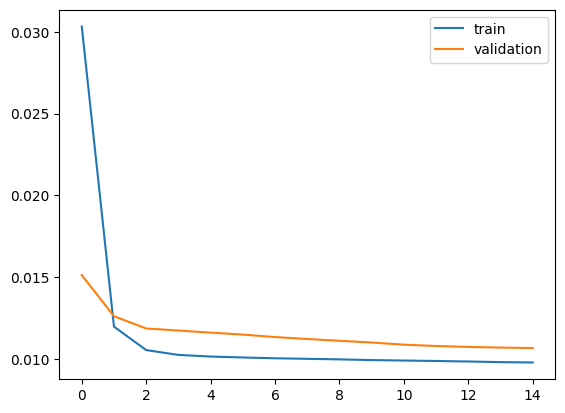

In [68]:
# plot the lost
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')

plt.legend()

In [69]:
# Fit a new scaler on the single feature you're predicting
scaler_single = MinMaxScaler()
scaler_single.fit(Y_test['var1(t)'].values.reshape(-1, 1))  # Reshape to 2D array


MinMaxScaler()

In [70]:
# Make predictions and plot them against the actual values
predictions = model.predict(test_X)


329/329 [==============================] - 5s 10ms/step


In [71]:

# Invert the predictions to the original scale
predictions = scaler_single.inverse_transform(predictions)


In [72]:
test_Y = scalery.inverse_transform(test_Y)
test_Y

array([[ 47.8596,  40.1275,  48.9501, ..., 148.072 ,  75.5379,  28.7943],
       [ 40.1275,  48.9501,  48.1567, ...,  75.5379,  28.7943,  30.9522],
       [ 48.9501,  48.1567,  53.2609, ...,  28.7943,  30.9522,  30.9522],
       ...,
       [632.185 , 547.601 , 506.603 , ...,      nan,      nan,      nan],
       [547.601 , 506.603 ,      nan, ...,      nan,      nan,      nan],
       [506.603 ,      nan,      nan, ...,      nan,      nan,      nan]])

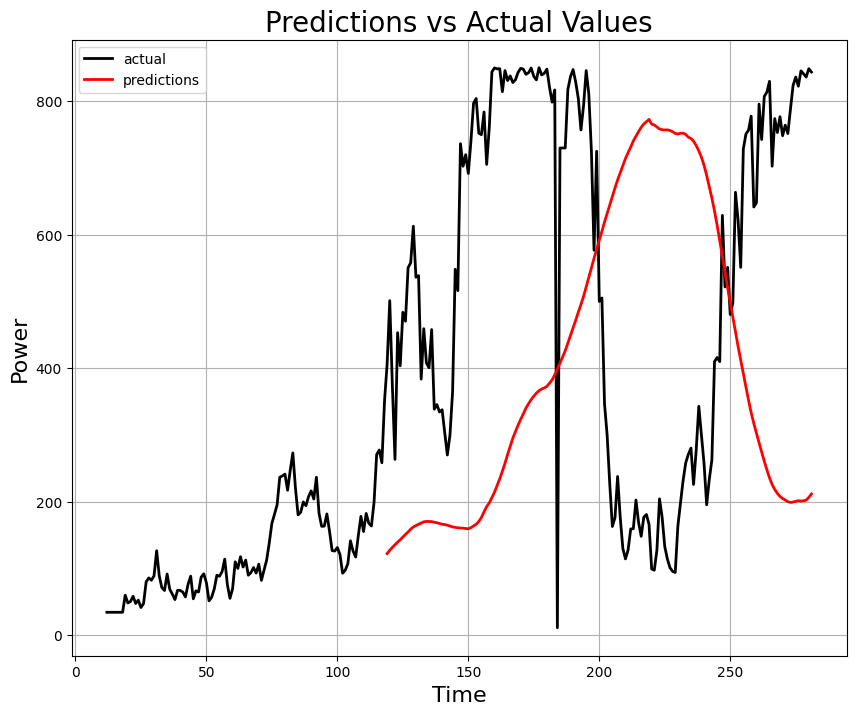

In [73]:

# plot the predictions
plt.figure(figsize=(10,8))

plt.plot(test_Y[150:144*3,-1], 'k', label='actual', linewidth=2)
plt.plot(predictions[150:144*3],'-r', label='predictions', linewidth=2)
plt.grid(True)

plt.title('Predictions vs Actual Values', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Power', fontsize=16)

plt.legend()

In [74]:
# import pandas and sklearn to get the R-squared value
import sklearn.metrics

# convert numpy arrays to pandas DataFrames
predictions_df = pd.DataFrame(predictions)
test_Y_df = pd.DataFrame(test_Y)

# drop NaN values
predictions_df = predictions_df.dropna()
test_Y_df = test_Y_df.dropna()

# calculate the R-squared of the model on the test set
r2 = sklearn.metrics.r2_score(test_Y_df, predictions_df)
r2 = sklearn.metrics.r2_score(test_Y, predictions)
r2

ValueError: Found input variables with inconsistent numbers of samples: [5759, 5040]